If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [1]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 26.3 MB/s 
     |████████████████████████████████| 4.9 MB 61.5 MB/s 
     |████████████████████████████████| 115 kB 75.1 MB/s 
     |████████████████████████████████| 212 kB 74.8 MB/s 
     |████████████████████████████████| 163 kB 68.9 MB/s 
     |████████████████████████████████| 127 kB 71.1 MB/s 
     |████████████████████████████████| 6.6 MB 56.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


Then you need to install Git-LFS. Uncomment the following instructions:

In [3]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [4]:
import transformers

print(transformers.__version__)

4.22.2


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/language-modeling).

# Train a language model

In this notebook, we'll see how to train a [🤗 Transformers](https://github.com/huggingface/transformers) model on a language modeling task. We will cover two types of language modeling tasks which are:

- Causal language modeling: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.

![Widget inference representing the causal language modeling task](https://github.com/huggingface/notebooks/blob/main/examples/images/causal_language_modeling.png?raw=1)

- Masked language modeling: the model has to predict some tokens that are masked in the input. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.

![Widget inference representing the masked language modeling task](https://github.com/huggingface/notebooks/blob/main/examples/images/masked_language_modeling.png?raw=1)

We will see how to easily load and preprocess the dataset for each one of those tasks, and how to use the `Trainer` API to train a model on it.

This notebooks assumes you have trained a tokenizer on the corpus you are using, see the [How to train a tokenizer](https://github.com/huggingface/notebooks/blob/master/examples/tokenizer_training.ipynb) notebook ([open in colab](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/tokenizer_training.ipynb)).

A script version of this notebook you can directly run on a distributed environment or on TPU is available in our [examples folder](https://github.com/huggingface/transformers/tree/master/examples).

## Preparing the dataset

For each of those tasks, we will use the [Wikitext 2]() dataset as an example. You can load it very easily with the 🤗 Datasets library.

In [5]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

You can replace the dataset above with any dataset hosted on [the hub](https://huggingface.co/datasets) or use your own files. Just uncomment the following cell and replace the paths with values that will lead to your files:

In [ ]:
# datasets = load_dataset("text", data_files={"train": path_to_train.txt, "validation": path_to_validation.txt}

You can also load datasets from a csv or a JSON file, see the [full documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) for more information.

To access an actual element, you need to select a split first, then give an index:

In [6]:
datasets["train"][10]

{'text': ' The game \'s battle system , the BliTZ system , is carried over directly from Valkyira Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action Gauge . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by the story and can either help or impede

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [7]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [9]:
show_random_elements(datasets["train"])

,text
0,"Joaquín Balaguer , Trujillo 's puppet president is also a supporter , and initially his seemingly innocuous character holds no real power . Following Trujillo 's death , the calm and serenity of Balaguer bring about real change in his character , and General Román comments that "" this insignificant man whom everyone had always considered a mere clerk , a purely decorative figure in the regime , began to acquire surprising authority "" . It is Balaguer who guides much of the action in the last sections of the book . \n"
1,"However he struggled with poor form during the 1950 – 51 season as his first marriage was coming to an end and he came into increasing conflict with his teammates . He was angered when the club sold Jackie Sewell to Sheffield Wednesday in March 1951 – breaking Lawton 's own transfer record in the process – as he felt the move showed a lack of ambition from the club 's directors . He also found that the well paid job he was promised outside of football did not transpire . His tally of nine goals in 31 games in 1950 – 51 and 13 goals in 31 games in 1951 – 52 was disappointing , and he was made available for transfer . \n"
2,"According to Reena Jana from Business Week , The Clean Tech Revolution is a "" readable , straightforward guide to earth @-@ friendly business strategies "" . The authors explain how businesses can follow the lead of companies such as Toyota by designing , selling , or funding inventive eco @-@ friendly products and services . Jana says that the Toyota Prius is just one well @-@ known example of successful clean technology in action . \n"
3,
4,"Fowler is best remembered for his time at Liverpool and is the sixth @-@ highest goalscorer in the history of the Premier League . He scored 183 goals in total for Liverpool , 128 of which were scored in the Premier League ( 162 Premier League goals in total ) . He earned the nickname "" God "" from the Anfield crowd , becoming a club legend due to his ruthlessness in front of goal . He subsequently played for Leeds United and Manchester City , before returning to Liverpool in January 2006 . \n"
5,
6,"In May 2009 , the Court of Appeal ruled that photographs collected by FITs of people who have not committed a criminal offence can no longer be kept . The ruling was made after Andrew Wood , an arms trade activist , was photographed after challenging the management of Reed Elsevier at their AGM over them organising arms trade exhibitions . Wood argued that police had harassed him and infringed his right to privacy by photographing him . Lord Collins of Mapesbury said that the police presence had a "" chilling effect "" on people who were protesting lawfully . FITs have not been banned but they must now justify the retention of photographs on a case @-@ by @-@ case basis . As a result of the ruling the Metropolitan Police 's public order unit , CO11 was forced to delete 40 % of the photos of protesters that it held . \n"
7,Credits are adapted from the album 's liner notes . \n
8,"The 130th Engineer Brigade turned over responsibility as Operation Enduring Freedom 's Theater Engineer Brigade to the 2nd Engineer Brigade ( from Joint Base Elmedorf @-@ Richardson , AK ) , Joint Task Force Trailblazer , on 29 May 2014 . The 130th Engineer Brigade returned to Schofield Barracks , Hawaii from Afghanistan on 4 June 2014 . \n"
9,


As we can see, some of the texts are a full paragraph of a Wikipedia article while others are just titles or empty lines.

## Causal Language modeling

What we mean under tokenization?
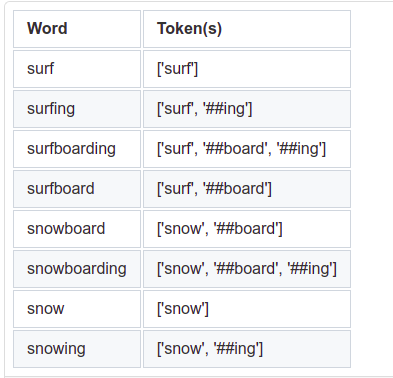

For causal language modeling (CLM) we are going to take all the texts in our dataset and concatenate them after they are tokenized. Then we will split them in examples of a certain sequence length. This way the model will receive chunks of contiguous text that may look like:
```
part of text 1
```
or 
```
end of text 1 [BOS_TOKEN] beginning of text 2
```
depending on whether they span over several of the original texts in the dataset or not. The labels will be the same as the inputs, shifted to the left.

We will use the [`gpt2`](https://huggingface.co/gpt2) architecture for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=causal-lm) instead. For the tokenizer, you can replace the checkpoint by the one you trained yourself.

In [10]:
model_checkpoint = "gpt2"
tokenizer_checkpoint = "sgugger/gpt2-like-tokenizer"

To tokenize all our texts with the same vocabulary that was used when training the model, we have to download a pretrained tokenizer. This is all done by the `AutoTokenizer` class:

In [11]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

Downloading:   0%|          | 0.00/236 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/396k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/678k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

We can now call the tokenizer on all our texts. This is very simple, using the [`map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) method from the Datasets library. First we define a function that call the tokenizer on our texts:

In [12]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

Then we apply it to all the splits in our `datasets` object, using `batched=True` and 4 processes to speed up the preprocessing. We won't need the `text` column afterward, so we discard it.

In [13]:
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#0:   0%|          | 0/10 [00:00<?, ?ba/s]

#1:   0%|          | 0/10 [00:00<?, ?ba/s]

#3:   0%|          | 0/10 [00:00<?, ?ba/s]

#2:   0%|          | 0/10 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

If we now look at an element of our datasets, we will see the text have been replaced by the `input_ids` the model will need:

In [15]:
tokenized_datasets["train"][2]

{'input_ids': [], 'attention_mask': []}

Now for the harder part: we need to concatenate all our texts together then split the result in small chunks of a certain `block_size`. To do this, we will use the `map` method again, with the option `batched=True`. This option actually lets us change the number of examples in the datasets by returning a different number of examples than we got. This way, we can create our new samples from a batch of examples.

First, we grab the maximum length our model was pretrained with. This might be a big too big to fit in your GPU RAM, so here we take a bit less at just 128.

In [16]:
block_size = 128

Then we write the preprocessing function that will group our texts:

In [17]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

First note that we duplicate the inputs for our labels. This is because the model of the 🤗 Transformers library apply the shifting to the right, so we don't need to do it manually.

Also note that by default, the `map` method will send a batch of 1,000 examples to be treated by the preprocessing function. So here, we will drop the remainder to make the concatenated tokenized texts a multiple of `block_size` every 1,000 examples. You can adjust this behavior by passing a higher batch size (which will also be processed slower). You can also speed-up the preprocessing by using multiprocessing:

In [18]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

#0:   0%|          | 0/10 [00:00<?, ?ba/s]

#1:   0%|          | 0/10 [00:00<?, ?ba/s]

#2:   0%|          | 0/10 [00:00<?, ?ba/s]

#3:   0%|          | 0/10 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

And we can check our datasets have changed: now the samples contain chunks of `block_size` contiguous tokens, potentially spanning over several of our original texts.

In [19]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

' the " Nameless ", a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven ". \n The game began development in 2010, carrying over a large portion of the work done on Valkyria Chronicles II. While it retained the standard features of the series, it also underwent multiple adjustments, such as making the game more forgiving for series newcomers. Character designer Raita Honjou and composer Hitoshi Sakimoto both returned from previous entries, along with Valkyria Chronicles II director Takeshi Ozawa. A large'

Now that the data has been cleaned, we're ready to instantiate our `Trainer`. First we create the model using the same config as our checkpoint, but initialized with random weights:

In [20]:
from transformers import AutoConfig, AutoModelForCausalLM

config = AutoConfig.from_pretrained(model_checkpoint)
model = AutoModelForCausalLM.from_config(config)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [21]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

And we will needsome `TrainingArguments`:

In [22]:
from transformers import Trainer, TrainingArguments

In [23]:
?TrainingArguments

In [24]:
training_args = TrainingArguments( 
    f"{model_checkpoint}-wikitext2",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=True,
)

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/gpt-finetuned-wikitext2"` or `"huggingface/gpt-finetuned-wikitext2"`).

We pass along all of those to the `Trainer` class:

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)

Cloning https://huggingface.co/magistrkoljan/gpt2-wikitext2 into local empty directory.


And we can train our model:

In [26]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 17991
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6747


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

Once the training is completed, we can evaluate our model and get its perplexity on the validation set like this:

In [27]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 1934
  Batch size = 8


Epoch,Training Loss,Validation Loss
0,No log,7.872084


Perplexity: 2623.03


The perplexity is still quite high since for this demo we trained on a small dataset for a small number of epochs. For a real LM training, you  would need a larger dataset and more epochs.

You can now upload the result of the training to the Hub, just execute this instruction:

In [28]:
trainer.push_to_hub()

Saving model checkpoint to gpt2-wikitext2
Configuration saved in gpt2-wikitext2/config.json
Model weights saved in gpt2-wikitext2/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/487M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

Upload file runs/Oct04_09-48-09_92255121966f/1664876942.5227401/events.out.tfevents.1664876942.92255121966f.68…

Upload file runs/Oct04_09-48-09_92255121966f/events.out.tfevents.1664876942.92255121966f.68.0:  81%|########1 …

KeyboardInterrupt: ignored

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("sgugger/my-awesome-model")
```

## Masked language modeling

For masked language modeling (MLM) we are going to use the same preprocessing as before for our dataset with one additional step: we will randomly mask some tokens (by replacing them by `[MASK]`) and the labels will be adjusted to only include the masked tokens (we don't have to predict the non-masked tokens). If you use a tokenizer you trained yourself, make sure the `[MASK]` token is among the special tokens you passed during training!

We will use the [`bert-base-cased`](https://huggingface.co/bert-based-cased) model for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=masked-lm) instead. For the tokenizer, replace the checkpoint by the one you trained.

In [29]:
model_checkpoint = "bert-base-cased"
tokenizer_checkpoint = "sgugger/bert-like-tokenizer"

We can apply the same tokenization function as before, we just need to update our tokenizer to use the checkpoint we just picked:

In [30]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/175k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/365k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sgugger--bert-like-tokenizer/snapshots/01644691345d776b01e25b0093968d2401a2310b/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--sgugger--bert-like-tokenizer/snapshots/01644691345d776b01e25b0093968d2401a2310b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--sgugger--bert-like-tokenizer/snapshots/01644691345d776b01e25b0093968d2401a2310b/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--sgugger--bert-like-tokenizer/snapshots/01644691345d776b01e25b0093968d2401a2310b/tokenizer_config.json


#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors


#0:   0%|          | 0/10 [00:00<?, ?ba/s]

#1:   0%|          | 0/10 [00:00<?, ?ba/s]

#3:   0%|          | 0/10 [00:00<?, ?ba/s]

#2:   0%|          | 0/10 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

And like before, we group texts together and chunk them in samples of length `block_size`. You can skip that step if your dataset is composed of individual sentences.

In [31]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

#0:   0%|          | 0/10 [00:00<?, ?ba/s]

#1:   0%|          | 0/10 [00:00<?, ?ba/s]

#3:   0%|          | 0/10 [00:00<?, ?ba/s]

#2:   0%|          | 0/10 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

The rest is very similar to what we had, with two exceptions. First we use a model suitable for masked LM:

In [32]:
from transformers import AutoConfig, AutoModelForMaskedLM

config = AutoConfig.from_pretrained(model_checkpoint)
model = AutoModelForMaskedLM.from_config(config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/a8d257ba9925ef39f3036bfc338acf5283c512d9/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



We redefine our `TrainingArguments`:

In [33]:
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [34]:
training_args = TrainingArguments(
    "test-clm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=True,
    push_to_hub_model_id=f"{model_checkpoint}-wikitext2",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/training_args.py:1261: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case magistrkoljan/bert-base-cased-wikitext2).
  FutureWarning,


Like before, the last two arguments are to setup everything so we can push the model to the [Hub](https://huggingface.co/models) at the end of training. Remove the two of them if you didn't follow the installation steps at the top of the notebook, otherwise you can change the value of `push_to_hub_model_id` to something you would prefer.

Finally, we use a special `data_collator`. The `data_collator` is a function that is responsible of taking the samples and batching them in tensors. In the previous example, we had nothing special to do, so we just used the default for this argument. Here we want to do the random-masking. We could do it as a pre-processing step (like the tokenization) but then the tokens would always be masked the same way at each epoch. By doing this step inside the `data_collator`, we ensure this random masking is done in a new way each time we go over the data.

To do this masking for us, the library provides a `DataCollatorForLanguageModeling`. We can adjust the probability of the masking:

In [35]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

Then we just have to pass everything to `Trainer` and begin training:

In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    data_collator=data_collator,
)

Cloning https://huggingface.co/magistrkoljan/bert-base-cased-wikitext2 into local empty directory.


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 18761
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7038
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

Like before, we can evaluate our model on the validation set. The perplexity is much lower than for the CLM objective because for the MLM objective, we only have to make predictions for the masked tokens (which represent 15% of the total here) while having access to the rest of the tokens. It's thus an easier task for the model.

In [ ]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 2009
  Batch size = 8


Epoch,Training Loss,Validation Loss
0,No log,9.287101


Perplexity: 10797.83


The perplexity is still quite high since for this demo we trained on a small dataset for a small number of epochs. For a real LM training, you  would need a larger dataset and more epochs.

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForMaskedLM

model = AutoModelForMaskedLM.from_pretrained("sgugger/my-awesome-model")
```

# Fine-tuning a model on a text classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a text classification task of the [GLUE Benchmark](https://gluebenchmark.com/).


The GLUE Benchmark is a group of nine classification tasks on sentences or pairs of sentences which are:

- [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability) Determine if a sentence is grammatically correct or not.is a  dataset containing sentences labeled grammatically correct or not.
- [MNLI](https://arxiv.org/abs/1704.05426) (Multi-Genre Natural Language Inference) Determine if a sentence entails, contradicts or is unrelated to a given hypothesis. (This dataset has two versions, one with the validation and test set coming from the same distribution, another called mismatched where the validation and test use out-of-domain data.)
- [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus) Determine if two sentences are paraphrases from one another or not.
- [QNLI](https://rajpurkar.github.io/SQuAD-explorer/) (Question-answering Natural Language Inference) Determine if the answer to a question is in the second sentence or not. (This dataset is built from the SQuAD dataset.)
- [QQP](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) (Quora Question Pairs2) Determine if two questions are semantically equivalent or not.
- [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment) (Recognizing Textual Entailment) Determine if a sentence entails a given hypothesis or not.
- [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank) Determine if the sentence has a positive or negative sentiment.
- [STS-B](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) (Semantic Textual Similarity Benchmark) Determine the similarity of two sentences with a score from 1 to 5.
- [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html) (Winograd Natural Language Inference) Determine if a sentence with an anonymous pronoun and a sentence with this pronoun replaced are entailed or not. (This dataset is built from the Winograd Schema Challenge dataset.)

We will see how to easily load the dataset for each one of those tasks and use the `Trainer` API to fine-tune a model on it. Each task is named by its acronym, with `mnli-mm` standing for the mismatched version of MNLI (so same training set as `mnli` but different validation and test sets):

In [37]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

This notebook is built to run on any of the tasks in the list above, with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a classification head. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [39]:
task = "cola"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [40]:
from datasets import load_dataset, load_metric

Apart from `mnli-mm` being a special code, we can directly pass our task name to those functions. `load_dataset` will cache the dataset to avoid downloading it again the next time you run this cell.

In [41]:
actual_task = "mnli" if task == "mnli-mm" else task
dataset = load_dataset("glue", actual_task)
metric = load_metric('glue', actual_task)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set (with more keys for the mismatched validation and test set in the special case of `mnli`).

In [42]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

To access an actual element, you need to select a split first, then give an index:

In [43]:
dataset["train"][0]

{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.",
 'label': 1,
 'idx': 0}

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [44]:
show_random_elements(dataset["train"])

,sentence,label,idx
0,"I acknowledged that my father, he was tight as an owl.",unacceptable,1824
1,For him to do that would be a mistake.,acceptable,409
2,"Mary sang a song, but Lee never did.",acceptable,4506
3,John made Mary cooking Korean food.,unacceptable,4012
4,John sounded in the park.,unacceptable,3657
5,Clouds cleared from the sky.,acceptable,2286
6,It is this hat that that he was wearing is certain.,unacceptable,1679
7,Who are you gawking at?,acceptable,1424
8,Captain Oates died in order to save his comrades.,acceptable,6912
9,The tree dropped fruit to the ground.,acceptable,520


The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [45]:
metric

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

You can call its `compute` method with your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [46]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'matthews_correlation': 0.14462158210542375}

Note that `load_metric` has loaded the proper metric associated to your task, which is:

- for CoLA: [Matthews Correlation Coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)
- for MNLI (matched or mismatched): Accuracy
- for MRPC: Accuracy and [F1 score](https://en.wikipedia.org/wiki/F1_score)
- for QNLI: Accuracy
- for QQP: Accuracy and [F1 score](https://en.wikipedia.org/wiki/F1_score)
- for RTE: Accuracy
- for SST-2: Accuracy
- for STS-B: [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [Spearman's_Rank_Correlation_Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)
- for WNLI: Accuracy

so the metric object only computes the one(s) needed for your task.

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [47]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.22.2",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropo

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [48]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [101, 7592, 1010, 2023, 2028, 6251, 999, 102, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

In [49]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

We can double check it does work on our current dataset:

In [50]:
sentence1_key, sentence2_key = task_to_keys[task]
if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: Our friends won't buy this analysis, let alone the next one we propose.


We can then write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model.

In [51]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [52]:
preprocess_function(dataset['train'][:5])

{'input_ids': [[101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 2028, 2062, 18404, 2236, 3989, 2030, 1045, 1005, 1049, 3228, 2039, 1012, 102], [101, 1996, 2062, 2057, 2817, 16025, 1010, 1996, 13675, 16103, 2121, 2027, 2131, 1012, 102], [101, 2154, 2011, 2154, 1996, 8866, 2024, 2893, 14163, 8024, 3771, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [53]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `AutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2, except for STS-B which is a regression problem and MNLI where we have 3 labels):

In [54]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 3 if task.startswith("mnli") else 1 if task=="stsb" else 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.22.2",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [55]:
metric_name = "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-mrpc"` or `"huggingface/bert-finetuned-mrpc"`).

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B):

In [56]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [57]:
validation_key = "validation_mismatched" if task == "mnli-mm" else "validation_matched" if task == "mnli" else "validation"
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/magistrkoljan/distilbert-base-uncased-finetuned-cola into local empty directory.


You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

We can now finetune our model by just calling the `train` method:

In [58]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8551
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2675
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to enco

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.522700,0.522218,0.420980
2,0.346600,0.504839,0.483239
3,0.233500,0.564130,0.517280
4,0.181200,0.763801,0.520022
5,0.133400,0.812270,0.536397


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1043
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-cola/checkpoint-535
Configuration saved in distilbert-base-uncased-finetuned-cola/checkpoint-535/config.json
Model weights saved in distilbert-base-uncased-finetuned-cola/checkpoint-535/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-cola/checkpoint-535/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-cola/checkpoint-535/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-cola/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-cola/sp

TrainOutput(global_step=2675, training_loss=0.272571696343823, metrics={'train_runtime': 180.7186, 'train_samples_per_second': 236.583, 'train_steps_per_second': 14.802, 'total_flos': 229309863736728.0, 'train_loss': 0.272571696343823, 'epoch': 5.0})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [59]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1043
  Batch size = 16


{'eval_loss': 0.8122702836990356,
 'eval_matthews_correlation': 0.5363967157085073,
 'eval_runtime': 0.9035,
 'eval_samples_per_second': 1154.441,
 'eval_steps_per_second': 73.052,
 'epoch': 5.0}

To see how your model fared you can compare it to the [GLUE Benchmark leaderboard](https://gluebenchmark.com/leaderboard).

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("sgugger/my-awesome-model")
```

## Hyperparameter search

The `Trainer` supports hyperparameter search using [optuna](https://optuna.org/) or [Ray Tune](https://docs.ray.io/en/latest/tune/). For this last section you will need either of those libraries installed, just uncomment the line you want on the next cell and run it.

In [ ]:
# ! pip install optuna
# ! pip install ray[tune]

During hyperparameter search, the `Trainer` will run several trainings, so it needs to have the model defined via a function (so it can be reinitialized at each new run) instead of just having it passed. We jsut use the same function as before:

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

And we can instantiate our `Trainer` like before:

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

The method we call this time is `hyperparameter_search`. Note that it can take a long time to run on the full dataset for some of the tasks. You can try to find some good hyperparameter on a portion of the training dataset by replacing the `train_dataset` line above by:
```python
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 
```
for 1/10th of the dataset. Then you can run a full training on the best hyperparameters picked by the search.

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2020-10-15 17:06:50,302] A new study created in memory with name: no-name-5ca133fa-884f-4b0b-beb6-82fb19c9da06
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpo

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.567259,0.567516,0.267643
2,0.424672,0.588076,0.360967
3,0.304736,0.882551,0.373388
4,0.172879,1.131409,0.427625


[I 2020-10-15 17:08:54,670] Trial 0 finished with value: 0.4276247641425646 and parameters: {'learning_rate': 9.066394855554376e-05, 'num_train_epochs': 4, 'seed': 3, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.4276247641425646.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.498541,0.470532,0.480649


[I 2020-10-15 17:09:27,505] Trial 1 finished with value: 0.4806486312161432 and parameters: {'learning_rate': 4.70956471834944e-05, 'num_train_epochs': 1, 'seed': 40, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.4806486312161432.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.467531,0.446775
2,0.428433,0.476509,0.521516


[I 2020-10-15 17:09:51,733] Trial 2 finished with value: 0.5215162259225145 and parameters: {'learning_rate': 4.357724525964853e-05, 'num_train_epochs': 2, 'seed': 38, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 0.5215162259225145.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model fr

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.526249,0.488950,0.412369
2,0.344729,0.505700,0.505773
3,0.242301,0.565479,0.514625


[I 2020-10-15 17:10:42,034] Trial 3 finished with value: 0.5146251651052666 and parameters: {'learning_rate': 1.966064728684351e-05, 'num_train_epochs': 3, 'seed': 4, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.5215162259225145.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model fro

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.619170,0.615369,0.000000


/home/sgugger/.pyenv/versions/3.7.9/envs/base/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
[I 2020-10-15 17:11:00,530] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 1.1681626444738994e-06, 'num_train_epochs': 1, 'seed': 35, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.5215162259225145.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).


Epoch,Training Loss,Validation Loss


/home/sgugger/.pyenv/versions/3.7.9/envs/base/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
[I 2020-10-15 17:11:16,708] Trial 5 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassifi

Epoch,Training Loss,Validation Loss


[I 2020-10-15 17:11:27,293] Trial 6 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_class

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.467245,0.477506


[I 2020-10-15 17:11:39,998] Trial 7 finished with value: 0.47750559698251505 and parameters: {'learning_rate': 8.294058232883187e-05, 'num_train_epochs': 1, 'seed': 14, 'per_device_train_batch_size': 64}. Best is trial 2 with value: 0.5215162259225145.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

Epoch,Training Loss,Validation Loss


/home/sgugger/.pyenv/versions/3.7.9/envs/base/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
[I 2020-10-15 17:11:50,629] Trial 8 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassifi

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.526511,0.487868,0.449608


[I 2020-10-15 17:12:09,216] Trial 9 finished with value: 0.4496077935780946 and parameters: {'learning_rate': 3.983123210032869e-05, 'num_train_epochs': 1, 'seed': 35, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.5215162259225145.


The `hyperparameter_search` method returns a `BestRun` objects, which contains the value of the objective maximized (by default the sum of all metrics) and the hyperparameters it used for that run.

In [ ]:
best_run

BestRun(run_id='2', objective=0.5215162259225145, hyperparameters={'learning_rate': 4.357724525964853e-05, 'num_train_epochs': 2, 'seed': 38, 'per_device_train_batch_size': 32})

You can customize the objective to maximize by passing along a `compute_objective` function to the `hyperparameter_search` method, and you can customize the search space by passing a `hp_space` argument to `hyperparameter_search`. See this [forum post](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10) for some examples.

To reproduce the best training, just set the hyperparameters in your `TrainingArgument` before creating a `Trainer`:

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.467531,0.446775
2,0.428433,0.476509,0.521516


TrainOutput(global_step=536, training_loss=0.4191349371155696)